In [456]:
import pandas as pd
import json
import sys
import glob
import graph_tool.all as gt
from datetime import datetime, date, time
from os import listdir
from os.path import isfile, join
import numpy as np
from scipy import stats
import math
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

statistics_dir = '/home/maniaa/ashes/code/statistics/'
stat_csv = [(statistics_dir + f) for f in listdir(statistics_dir) if (f.endswith(".csv") and isfile(join(statistics_dir, f)))]
stat_csv.sort()
stat_csv = stat_csv[1:]

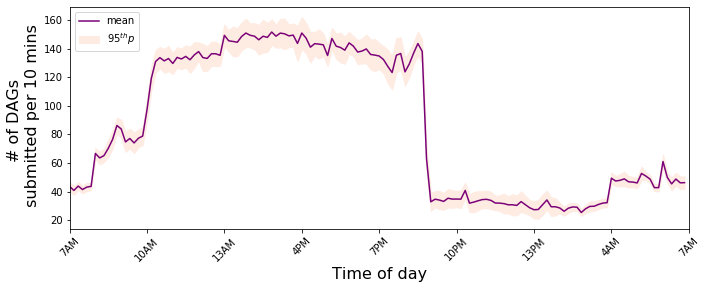

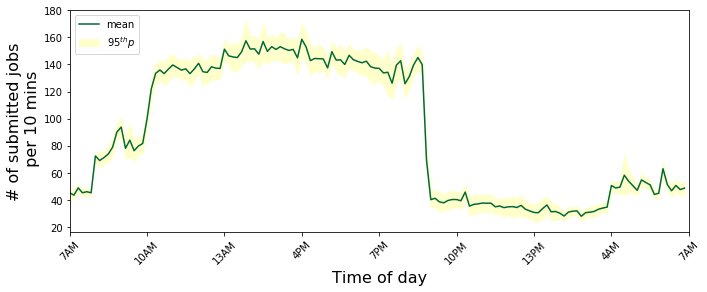

In [440]:
# DAG submission rate per day, every 10 minutes, aligend 7AM

from datetime import datetime

weekday = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Friday',
    5: 'Sat',
    6: 'Sun'
}
def format_xticks10min(x, pos=None):
    hour = (int(x)*600)//3600
    daytime = ''
    if 0 <= hour and hour < 7:
        daytime = 'AM'
        hour += 7;
    elif hour == 7:
        daytime = 'PM'
        hour += 7;
    elif 7 < hour and hour < 19:
        daytime = 'PM'
        hour -= 5;
    elif hour == 19:
        daytime = 'AM'
        hour -= 5;
    elif 19 < hour and hour <= 24:
        daytime = 'AM'
        hour -= 17;
    return str(hour) + daytime

dagsubmission_data = pd.DataFrame()
jobsubmission_data = pd.DataFrame()

for index, f in enumerate(stat_csv):
    # 6Am of each day
    month, day, year = f.split('/')[-1].split('.csv')[0].split('-')
    trace_starttime = datetime.combine(date(int(year), int(month), int(day)), time(7, 0))
    
    df = pd.read_csv(f)
    df = df[df['submitTime']/1000 > datetime.timestamp(trace_starttime)]
    
    df['submit_ts'] = (df['submitTime'] - datetime.timestamp(trace_starttime)*1000)//(10*60*1000);
            
    submitted_dag = pd.DataFrame()
    submitted_dag['submit_ts'] = df.groupby('workflow.id')['submit_ts'].agg('min');
    submitted_dag.sort_values('submit_ts', inplace=True)
    
    dagsubmission_data[f.split('/')[-1].split('.csv')[0]] = submitted_dag.groupby('submit_ts')['submit_ts'].agg('count')
    jobsubmission_data[f.split('/')[-1].split('.csv')[0]] = df.groupby('submit_ts')['submit_ts'].agg('count')
    
    if index == 30:
        break
        
# 50th Percentile
def q50(x):
            return x.quantile(0.5)

# 90th Percentile
def q95(x):
            return x.quantile(0.95)

# DAG submission rate
stats = dagsubmission_data.T.agg(['mean', 'count', 'std', 'median', 'max', 'min', q50, q95])
dagsubmission_data['mean'] = stats.T['mean']
dagsubmission_data['count'] = stats.T['count']
dagsubmission_data['std'] = stats.T['std']
dagsubmission_data['median'] = stats.T['median']
dagsubmission_data['max'] = stats.T['max']
dagsubmission_data['min'] = stats.T['min']
dagsubmission_data['95th'] = stats.T['q95']
dagsubmission_data['50_th'] = stats.T['q50']
dagsubmission_data['ci95_hi'] = dagsubmission_data['mean'] + 1.96*dagsubmission_data['std']/np.sqrt(dagsubmission_data['count'])
dagsubmission_data['ci95_lo'] = dagsubmission_data['mean'] - 1.96*dagsubmission_data['std']/np.sqrt(dagsubmission_data['count'])

fig, ax = plt.subplots(figsize=(10,4))
dagsubmission_data['mean'].plot(ax=ax, color='#7a0177', label='mean')
ax.fill_between(dagsubmission_data.index, (dagsubmission_data['ci95_lo']).values, 
                (dagsubmission_data['ci95_hi']).values, color='#feebe2', label=r'${95}^{th}p$')

plt.xticks(np.arange(0, 146, 18), rotation=45)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks10min))
plt.xlabel("Time of day", fontsize=16)
plt.ylabel("# of DAGs \n submitted per 10 mins", fontsize=16)
ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
fig.savefig('/home/maniaa/ashes/drawings/fig_querysubmissionrate_mean95.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_querysubmissionrate_mean95.png', format='png', dpi=200)
plt.show()

# Job submission rate
statsj = jobsubmission_data.T.agg(['mean', 'count', 'std', 'median', 'max', 'min', q50, q95])
jobsubmission_data['mean'] = statsj.T['mean']
jobsubmission_data['count'] = statsj.T['count']
jobsubmission_data['std'] = statsj.T['std']
jobsubmission_data['median'] = statsj.T['median']
jobsubmission_data['max'] = statsj.T['max']
jobsubmission_data['min'] = statsj.T['min']
jobsubmission_data['95th'] = statsj.T['q95']
jobsubmission_data['50_th'] = statsj.T['q50']
jobsubmission_data['ci95_hi'] = jobsubmission_data['mean'] + 1.96*jobsubmission_data['std']/np.sqrt(jobsubmission_data['count'])
jobsubmission_data['ci95_lo'] = jobsubmission_data['mean'] - 1.96*jobsubmission_data['std']/np.sqrt(jobsubmission_data['count'])

fig, ax = plt.subplots(figsize=(10,4))
jobsubmission_data['mean'].plot(ax=ax, color='#006837', label='mean')
ax.fill_between(jobsubmission_data.index, (jobsubmission_data['ci95_lo']).values, 
                (jobsubmission_data['ci95_hi']).values, color='#ffffcc', label=r'${95}^{th}p$')

plt.xticks(np.arange(0, 146, 18), rotation=45)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_xticks10min))
plt.xlabel("Time of day", fontsize=16)
plt.ylabel("# of submitted jobs\n per 10 mins", fontsize=16)
ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
fig.savefig('/home/maniaa/ashes/drawings/fig_jobsubmissionrate_mean95.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_jobsubmissionrate_mean95.png', format='png', dpi=200)
plt.show()

In [442]:
# interarrival time modeling
# Divide time into 3 intervals 
interarrival_data = pd.DataFrame()

def get_interarrival_values(group):
    return group['interarrival'].values

def get_time_zone(time):
    '''map the access time to three different 
    zones, 4AM-10AM, 10AM-9PM, 9PM-4AM'''
    if  (time > 0) and (time <= 18): # 4AM-10AM
        return 0;
    if (time > 18) and (time <= 84): # 10AM-9PM
        return 1;
    if (time > 84) and (time <= 126): # 9PM-4AM'
        return 2;
    return 0;
    
def aggregate_time_zones(group):
    interarrival_data = []
    for idx, row in group.iteritems():
        interarrival_data.extend(row)
    return interarrival_data

for index, f in enumerate(stat_csv):
    # 7Am of each day
    month, day, year = f.split('/')[-1].split('.csv')[0].split('-')
    trace_starttime = datetime.combine(date(int(year), int(month), int(day)), time(7, 0))
    
    df = pd.read_csv(f)
    df = df[df['submitTime']/1000 > datetime.timestamp(trace_starttime)]
    
    df['submit_ts'] = df['submitTime']//1000 - datetime.timestamp(trace_starttime);
    
    submitted_dag = pd.DataFrame()
    submitted_dag['submit_ts'] = df.groupby('workflow.id')['submit_ts'].agg('min');
    submitted_dag['submit_10min'] = submitted_dag['submit_ts']//(10*60);
    submitted_dag.sort_values('submit_ts', inplace=True)
    submitted_dag['interarrival'] = submitted_dag['submit_ts'].diff().fillna(0)    
    
    col_name = f.split('/')[-1].split('.csv')[0]
    interarrival_data[col_name] = submitted_dag.groupby('submit_10min').apply(get_interarrival_values)
    
    for row in interarrival_data.loc[interarrival_data[col_name].isnull(), col_name].index:
        interarrival_data.at[row, col_name] = np.array([])
    
    
    if 'total' in interarrival_data.columns:
        interarrival_data['total'] = interarrival_data[f.split('/')[-1].split('.csv')[0]].apply(lambda x: x.tolist()) + interarrival_data['total']
    else:
        interarrival_data['total'] = interarrival_data[f.split('/')[-1].split('.csv')[0]].apply(lambda x: x.tolist())        
    if index == 30:
        break
        
time_zones = interarrival_data.groupby(get_time_zone)['total'].apply(aggregate_time_zones)
print(time_zones)

0    [0.0, 12.0, 3.0, 28.0, 6.0, 24.0, 7.0, 1.0, 3....
1    [31.0, 2.0, 1.0, 0.0, 1.0, 9.0, 19.0, 1.0, 4.0...
2    [30.0, 15.0, 13.0, 9.0, 27.0, 5.0, 41.0, 39.0,...
Name: total, dtype: object


In [462]:
shape, loc, scale = stats.lognorm.fit(time_zones[0]) 
shape, loc, scale
np.log(scale), shape

(2.0793456872913225, 0.9213547514239753)

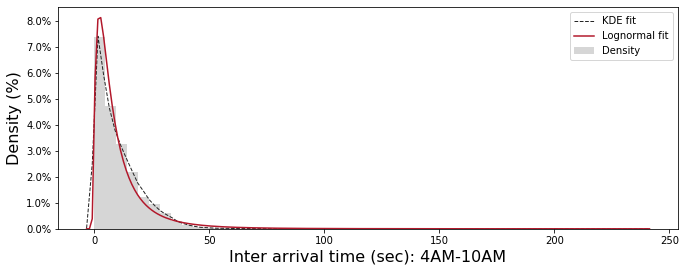

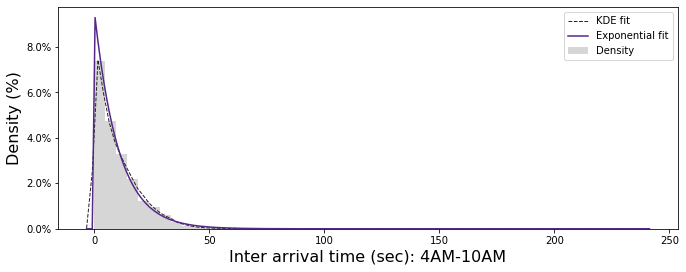

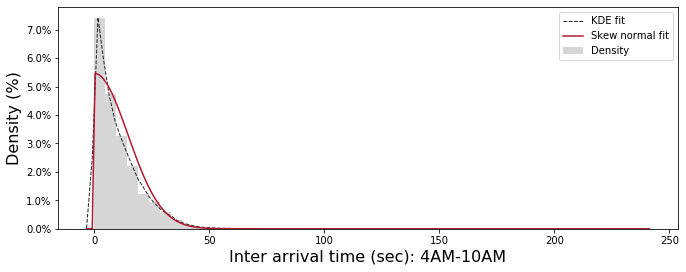

/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


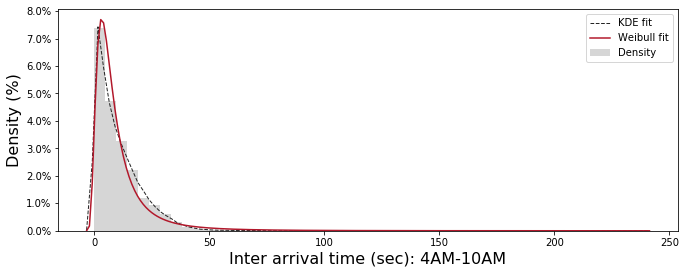

In [445]:


def format_yticksprobablity(x, pos=None):
    return str(round(100*x, 1)) + '%'

tzn = {0 : '4AM-10AM',
      1: '10AM-9PM',
      2: '9PM-4AM'}


fig, ax = plt.subplots(figsize=(10,4))
ret = sns.distplot(time_zones[0], fit=stats.lognorm, ax = ax,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Lognormal fit"}); # fitted to exponential 
plt.xlabel("Inter arrival time (sec): " + tzn[0], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_lognorm.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_lognorm.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[0], fit=stats.expon, ax =ax,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#542788', "lw": 1.5, "label": "Exponential fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[0], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_expon.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_expon.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[0], fit=stats.skewnorm,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Skew normal fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[0], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_skewnorm.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_skewnorm.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[0], fit=stats.invweibull,
            kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Weibull fit"}); # fitted to exponential );
plt.xlabel("Inter arrival time (sec): " + tzn[0], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_weibull.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_4am10am_weibull.png', format='png', dpi=200)
plt.show()

/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


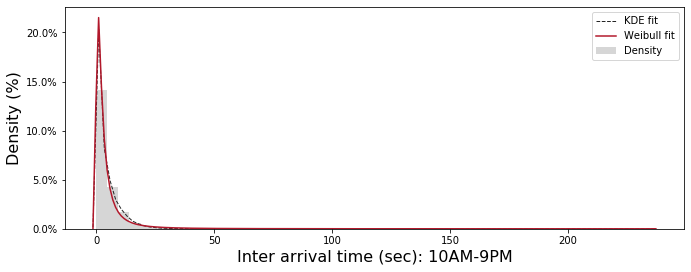

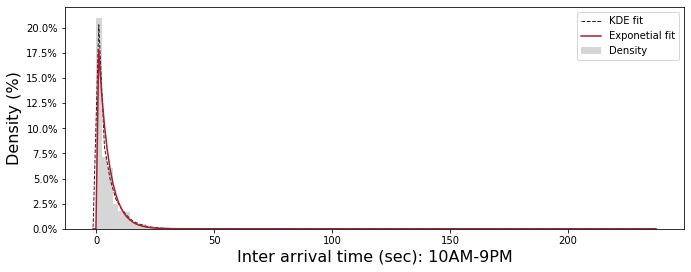

/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


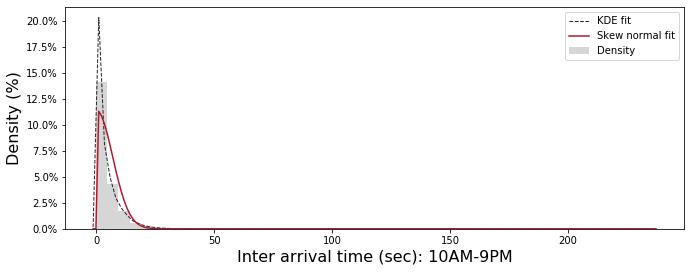

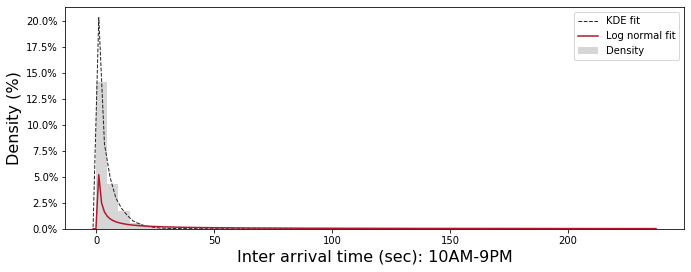

In [449]:
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[1], fit=stats.invweibull,
            kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Weibull fit"}); # fitted to exponential );
plt.xlabel("Inter arrival time (sec): " + tzn[1], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_weibull.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_weibull.png', format='png', dpi=200)
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[1], bins=100, fit=stats.expon,
            kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Exponetial fit"}); # fitted to exponential );
plt.xlabel("Inter arrival time (sec): " + tzn[1], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_expon.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_expon.png', format='png', dpi=200)
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[1], fit=stats.skewnorm,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Skew normal fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[1], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_skewnorm.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_skewnorm.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[1], fit=stats.lognorm,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Log normal fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[1], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_lognorm.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_10am9pm_lognorm.png', format='png', dpi=200)
plt.show()

/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1682: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


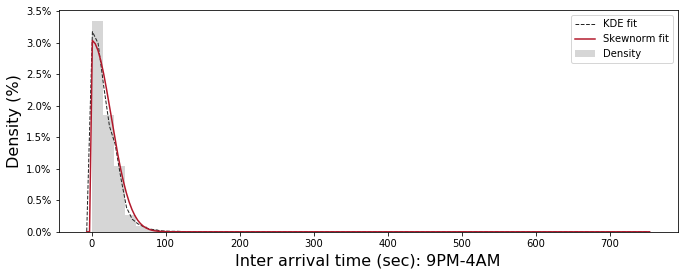

/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1059: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu
/home/maniaa/.local/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:2381: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


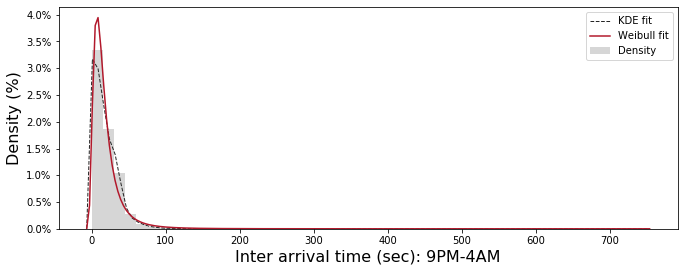

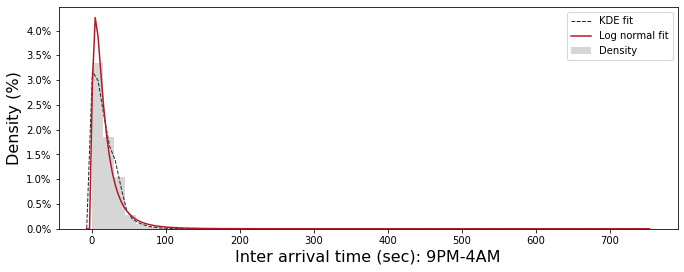

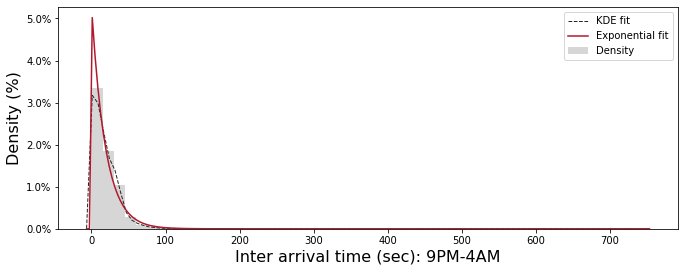

In [450]:
fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[2], fit=stats.skewnorm,
            kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Skewnorm fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[2], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_skewnorm.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_skewnorm.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[2], fit=stats.invweibull,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Weibull fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[2], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_weibull.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_weibull.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[2], fit=stats.lognorm,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Log normal fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[2], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_lognorm.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_lognorm.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
sns.distplot(time_zones[2], fit=stats.expon,
             kde_kws={"color": '#252525', "lw": 1, "label": "KDE fit", 'linestyle':'--'}, # Kernel density estimation
             hist_kws={"color": '#999999', "label": "Density"},
             fit_kws={"color": '#b2182b', "lw": 1.5, "label": "Exponential fit"});
plt.xlabel("Inter arrival time (sec): " + tzn[2], fontsize=16)
plt.ylabel("Density (%)", fontsize=16)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_yticksprobablity))
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
plt.legend()
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_expon.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histinterarrival_9pm4am_expon.png', format='png', dpi=200)
plt.show()

In [435]:
dagsubmission_data.fillna(0, inplace=True)
dagsubmission_data

,08-02-2018,08-03-2018,08-04-2018,08-05-2018,08-06-2018,08-07-2018,08-08-2018,08-09-2018,08-10-2018,08-11-2018,...,mean,count,std,median,max,min,95th,50_th,ci95_hi,ci95_lo
submit_ts,,,,,,,,,,,,,,,,,,,,,
0.0,42,45,37,35,23,41,36,49.0,0.0,44,...,43.566667,30.0,8.394100,45.5,63.0,23.0,54.65,45.5,46.570457,40.562876
1.0,43,43,43,32,21,48,32,44.0,17.0,39,...,40.806452,31.0,8.561228,42.0,60.0,17.0,50.50,42.0,43.820230,37.792673
2.0,48,46,47,35,23,50,30,41.0,58.0,42,...,43.838710,31.0,7.668536,45.0,58.0,23.0,56.00,45.0,46.538237,41.139182
3.0,50,40,42,31,18,46,34,44.0,51.0,36,...,41.419355,31.0,7.775064,42.0,55.0,18.0,51.00,42.0,44.156382,38.682327
4.0,45,48,40,34,19,45,42,41.0,57.0,50,...,43.129032,31.0,8.090084,43.0,57.0,19.0,54.50,43.0,45.976955,40.281109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139.0,52,29,48,32,47,50,55,47.0,59.0,61,...,49.935484,31.0,10.266241,51.0,71.0,20.0,62.50,51.0,53.549472,46.321496
140.0,54,17,44,25,36,50,52,50.0,57.0,58,...,45.387097,31.0,12.640352,46.0,72.0,17.0,62.00,46.0,49.836834,40.937359
141.0,50,15,59,23,46,37,55,46.0,59.0,64,...,48.741935,31.0,12.457843,50.0,66.0,15.0,64.00,50.0,53.127425,44.356446


In [453]:
jobsubmission_data.fillna(0, inplace=True)
jobsubmission_data.to_csv('/home/maniaa/ashes/stats/jobsubmission_data.csv')

In [454]:
dagsubmission_data.fillna(0, inplace=True)
dagsubmission_data.to_csv('/home/maniaa/ashes/stats/dagsubmission_data.csv')

0         3374.0
1         3401.0
2         3439.0
3         3462.0
4         3473.0
          ...   
12215    89928.0
12216    89943.0
12217    89952.0
12218    89960.0
12219    89971.0
Name: submit_ts, Length: 12220, dtype: float64


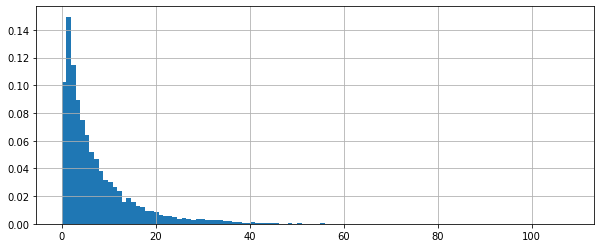

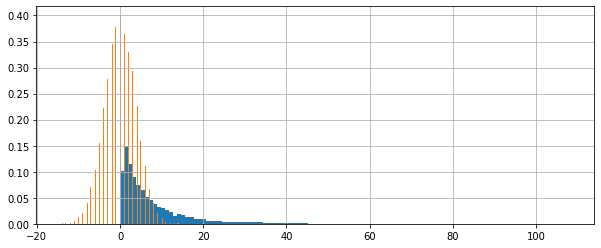

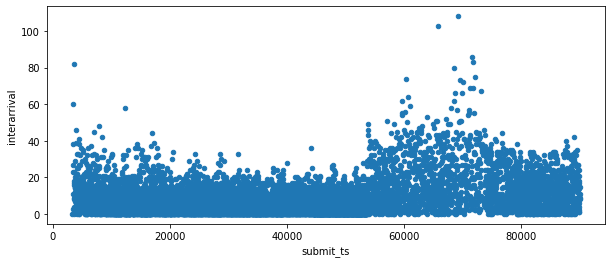

In [437]:
for index, f in enumerate(stat_csv):
    # 6Am of each day
    month, day, year = f.split('/')[-1].split('.csv')[0].split('-')
    trace_starttime = datetime.combine(date(int(year), int(month), int(day)), time(6, 0))
    
    df = pd.read_csv(f)
    df = df[df['submitTime']/1000 > datetime.timestamp(trace_starttime)]
    
    df['submit_ts'] = df['submitTime']//1000 - datetime.timestamp(trace_starttime);
    df.sort_values('submit_ts', inplace=True)
    df.reset_index(inplace=True)
        
    df['interarrival'] = df['submit_ts'].diff().fillna(0);
    pmu = df['interarrival'].mean();
    df['poisson'] = np.random.poisson(pmu, len(df['interarrival']))
    
    fig, ax = plt.subplots(figsize=(10,4))
    df['submit_ts'].diff().dropna().hist(ax=ax, bins=110, density=True)
    
    fig, ax = plt.subplots(figsize=(10,4))
    df['submit_ts'].diff().dropna().hist(ax=ax, bins=110, density=True)
    df['poisson'].diff().dropna().hist(ax=ax, bins=110, density=True)

    fig, ax = plt.subplots(figsize=(10,4))
    df.plot.scatter(ax=ax, x='submit_ts', y='interarrival')
    
    if index == 0:
        break

print(df['submit_ts'])

Min 	 Max 	 Mean 	 Standard deviation
0.0 	 108.0 	 7.26 		 8.75
0.0 	 553.0 	 6.75 		 11.5
0.0 	 435.0 	 10.42 		 15.82
0.0 	 268.0 	 6.51 		 10.36
0.0 	 145.0 	 7.15 		 10.07
0.0 	 243.0 	 6.5 		 10.0
0.0 	 230.0 	 6.42 		 9.13
0.0 	 324.0 	 6.96 		 9.86
0.0 	 116.0 	 6.56 		 8.58
0.0 	 154.0 	 5.97 		 8.15
0.0 	 252.0 	 6.0 		 8.5
0.0 	 572.0 	 6.67 		 11.05
0.0 	 211.0 	 5.81 		 8.8
0.0 	 134.0 	 5.87 		 8.8
0.0 	 197.0 	 6.95 		 8.93
0.0 	 747.0 	 7.11 		 11.67
0.0 	 103.0 	 7.09 		 8.7
0.0 	 181.0 	 7.16 		 8.66
0.0 	 107.0 	 6.93 		 8.88
0.0 	 331.0 	 7.27 		 11.47
0.0 	 236.0 	 8.2 		 10.94
0.0 	 848.0 	 8.0 		 12.64
0.0 	 156.0 	 6.92 		 8.85
0.0 	 391.0 	 5.96 		 8.0
0.0 	 563.0 	 7.61 		 11.63
0.0 	 412.0 	 7.52 		 11.92
0.0 	 218.0 	 7.12 		 10.25
0.0 	 288.0 	 8.19 		 12.94
0.0 	 171.0 	 7.83 		 10.63
0.0 	 202.0 	 7.08 		 9.16
0.0 	 214.0 	 6.9 		 8.83


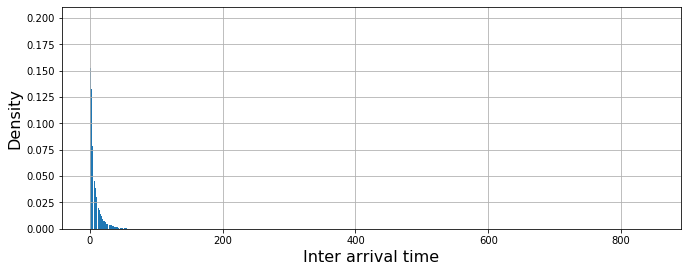

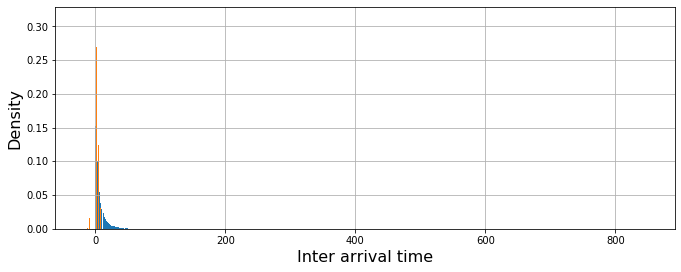

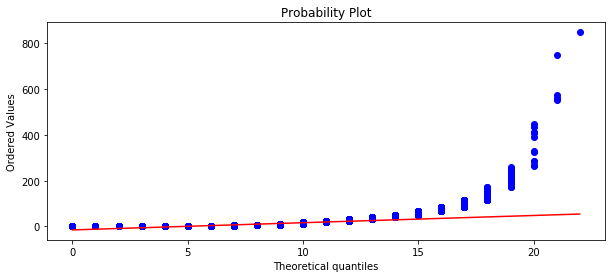

In [190]:
print('Min \t', 'Max \t', 'Mean \t', 'Standard deviation')

measurement = []

for index, f in enumerate(stat_csv):
    # 6Am of each day
    month, day, year = f.split('/')[-1].split('.csv')[0].split('-')
    trace_starttime = datetime.combine(date(int(year), int(month), int(day)), time(6, 0))
    
    df = pd.read_csv(f)
    df = df[df['submitTime']/1000 > datetime.timestamp(trace_starttime)]
    
    df['submit_ts'] = df['submitTime']//1000 - datetime.timestamp(trace_starttime);
    
    submitted_dag = pd.DataFrame()
    submitted_dag['submit_ts'] = df.groupby('workflow.id')['submit_ts'].agg('min');
    submitted_dag.sort_values('submit_ts', inplace=True)
    submitted_dag['interarrival'] = submitted_dag['submit_ts'].diff();
    
    measurement.extend(submitted_dag['interarrival'].dropna()[submitted_dag['interarrival'] < 3600].values)
    
    print(submitted_dag['interarrival'].min(), '\t',
          submitted_dag['interarrival'].max(), '\t',
          round(submitted_dag['interarrival'].mean(), 2), '\t\t', 
          round(submitted_dag['interarrival'].std(), 2))
    
    if index == 30:
        break

import scipy.stats as stats

df = pd.DataFrame({'interarrival': measurement, })
pmu = df['interarrival'].mean();
df['poisson'] = np.random.poisson(pmu, len(df['interarrival']))

fig, ax = plt.subplots(figsize=(10,4))
df['interarrival'].hist(bins=1000, density=True)
plt.xlabel("Inter arrival time", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
fig.savefig('/home/maniaa/ashes/drawings/fig_histogramsubmissionrate.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histogramsubmissionrate.png', format='png', dpi=200)
plt.show()

fig, ax = plt.subplots(figsize=(10,4))
df['interarrival'].hist(bins=1000, density=True)
df['poisson'].diff().dropna().hist(ax=ax, bins=110, density=True)
plt.xlabel("Inter arrival time", fontsize=16)
plt.ylabel("Density", fontsize=16)
plt.subplots_adjust(left=0.1, bottom=0.2, right=0.96, top=0.97)
fig.savefig('/home/maniaa/ashes/drawings/fig_histogramsubmissionratewpoissin.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histogramsubmissionratewpoissin.png', format='png', dpi=200)
plt.show()


fig, ax = plt.subplots(figsize=(10,4))
stats.probplot(np.array(measurement), dist=stats.poisson, 
               sparams=(np.array(measurement).mean(),), plot=ax)
fig.savefig('/home/maniaa/ashes/drawings/fig_histogramsubmissionrateqqplot.pdf', format='pdf', dpi=200)
fig.savefig('/home/maniaa/ashes/drawings/fig_histogramsubmissionrateqqplot.png', format='png', dpi=200)
plt.show()
